In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import os
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter
import matplotlib as mpl

from matplotlib import pyplot as plt
import plotly.graph_objects as go
plt.style.use('dark_background')
from pypalettes import load_cmap
import warnings
warnings.filterwarnings("ignore") 

import plotly.io as pio
pio.renderers.default = 'notebook'
import ipywidgets as widgets

import EmpiricalModels as model

cmap = plt.get_cmap('Pastel1')
plt.get_cmap('Pastel1')
palette = load_cmap('Alexandrite')

# LaTeP model: Emissivity cube

The output of the simulation is in the format of NetCDF files containing information about the X-ray photon production of each grid point in $[1/(cm^3 s)$. This is initially expressed in the local simulation coordinate system and has to be transported and interpolated into a GSE grid. In order to get the volume emissivity in $[eV cm^{-3} s^{-1}]$ we need to take into account that the number of test particles in simulation is far less than the number of physical particles. Each test particle is assigned a weight which is proportional to the number of physical particles, so that their contribution can be converted to the one of physical particles. After deriving this weight $w_0$, we can determine the number of physical particles of the species $\text{X}^{q+}$ by accounting for their relative abundance with respect to solar wind protons:

$$
N_{\text{X}^{q+}} = N_{\text{SW}} \cdot \left[ \frac{\text{X}^{q+}}{\text{O}} \right] \cdot \left[ \frac{\text{O}}{\text{H}^+} \right]
$$

where $N_{\text{SW}}$ and $N_{\text{X}^{q+}}$ represent the number of physical particles corresponding to solar wind protons and $\text{X}^{q+}$ ions, respectively {cite}`qiuyu`. The volume emissivity can therefore be derived from the production of the data cube through Equation {eq}`eq:emissivity`.

$$
    Q_{GSE} = P_{GSE} * w_0 * abundance
$$(eq:emissivity)

For the correct dimensionality of the integration of the emissivity along the LOS, we need to also convert the grid step to physical values, where each step corresponds to 0.05 RE

$$
    ds = 0.05 * R_{E} * 10^5 [cm]
$$

The `Cube` class has been defined to read the output cubes, convert it to physical quantities in the GSE frame, and provide functions to transform to other frames (ex. spherical).

Here we load the emissivity cube and transform it to the GSE frame:

In [ ]:
import ReadCube as readcube
cube = readcube.Cube("LaTeP_OpenGGCM", step=0.05)
Q_GSE = cube.Q_GSE()

We can visualize the integration from an infinitely distant POV of the Z and Y-axis through a discretized integration over them:

$$
    z_{POV} = \sum_z \frac{Q_{GSE}(x,y,z)}{4\pi} * ds
$$
$$
    y_{POV} = \sum_y \frac{Q_{GSE}(x,y,z)}{4\pi} * ds
$$

where we divide by $4\pi$ to get the emissivity per steradian. We can get this integration from the method `get_integration` of the `cube` object. This results in a large dynamic range of intensities $\in$ $[10^{-12},10^6]$ $eV/cm^2/s/sr$, with a significant contribution from the polar cusps. 

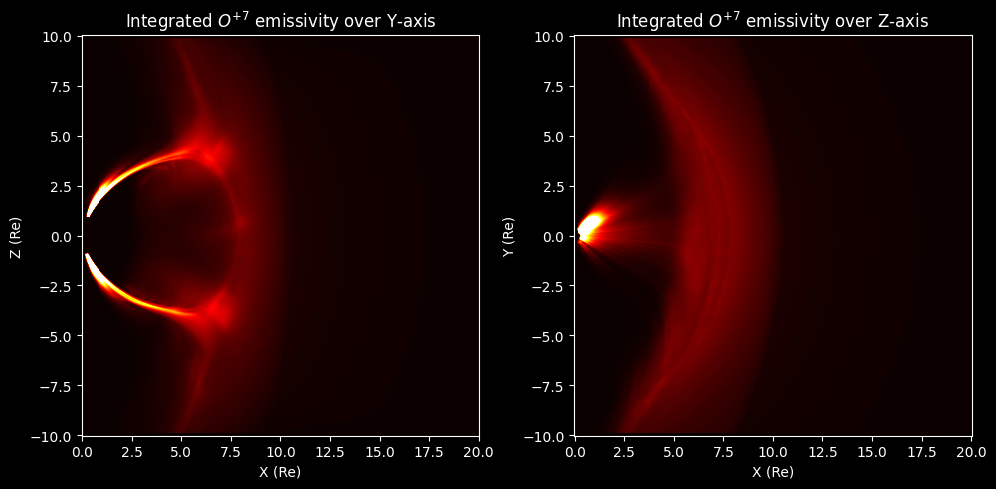

In [ ]:
y_integration = cube.get_intengration(axis=1)
z_integration = cube.get_intengration(axis=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(cube.x_GSE, cube.z_GSE,y_integration.T, cmap='hot',vmax =5e4)
axs[0].set_title("Integrated $O^{+7}$ emissivity over Y-axis")
axs[0].set_xlabel("X (Re)")
axs[0].set_ylabel("Z (Re)")
axs[1].pcolormesh(cube.x_GSE, cube.y_GSE,z_integration.T, cmap='hot',vmax =5e4)
axs[1].set_title("Integrated $O^{+7}$ emissivity over Z-axis")
axs[1].set_xlabel("X (Re)")
axs[1].set_ylabel("Y (Re)")
plt.tight_layout()
plt.show()

It is apparent that the study of the tangent hypothesis even for the simple case of an observer at infinity as studied by {cite}`sun_2020`, is not as straight forward for the test particle model. The smooth gradients of purely MHD models greatly simplify the process of extracting the maximum intensity arc, whereas the kinetic effects of the LaTeP model introduce prominent structures, jumps and contribution form the cusps. 

```{figure} ./images/cube/lines.png
:scale: 50%
:align: right
:name: fig:lines
Integration over z.
```

We can run a test to verify this by comparing the maximum intensity per line to the projection of the MHD input mangetopause. We extract the latter for the $z=0$ slice of the MHD input cube, by finding the boundary of the closed magnetic field lines (this operation was performed by Qiuyu and is not included in the notebook). Additionally, we can mask a $4RE$ radius sphere to reject the low altitude cusp contribution. The result is shown in {numref}`fig:lines`, where the blue dashed line is the maximum intensity and the red line the projected closed field line boundary. The black line represents the Shue model, constructed from the input parameters of the OpenGGCM simulation ({numref}`tab:parameters`).

```{table} Initial OpenGGCM simulation parameters.
:name: tab:parameters

| Parameter                      | Value          |
|-------------------------------|----------------|
| IMF \(B_z\)                   | $-5$ nT        |
| Solar Wind Velocity \(v_x\)   | $-400$ m/s     |
| Solar Wind Density \(n\)      | $12.5$ /cm³    |
| Solar Wind Dynamic Pressure \(P_{Dyn}\) | $3.84$ nPa     |
```



Although at the edges, the projected magnetopause coincides with the maximum intensity, the contribution of the cusps extends further than the mask at low polar angles and the two lines significantly diviate. The parametrization of the Shue model also does not represent this simulation, meaning that there is no agreement between the simulation parameters and the subsolar distance $r_0$ the shue model estimates. This however does not mean we cannot still utilize the model as a purely geometrical description. 
